# Robustness Analysis: Multiplicative vs Additive Errors

This notebook compares the effectiveness of the toggling-frame robustness objective for both multiplicative and additive errors. It's strucuted as follows:
* Imports & Setup
* Unitary Smooth Pulse Problem: Here we compare the effect of the toggling frame robustness objective on additive and multiplicative errors without any variational states.
* Unitary Variational Pulse Problem: Adjoint, Toggling, Adjoint + Toggling Comparison: Here we compare the effect of the toggling frame robustness relative to the existing adjoint robustness objective on both additive and multiplicative errors (with variational states)

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`


In [4]:
# Problem parameters
T = 50
Δt = 0.2
U_goal = GATES.X
H_drive = [PAULIS.X, PAULIS.Y]
Hₑ = PAULIS.X
rob_scale = 1.0
a_bound = 0.2
da_bound=Inf
dda_bound = 1.0
Q_s = 1e-2
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);

In [3]:
# Default
# H = a₁X + a₂Y
sys = QuantumSystem(H_drive)

# Additive case
# H = a₁X + a₂Y
# H_var = [X, X]
varsys_add = VariationalQuantumSystem(
    a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
    [a -> PAULIS.X,  a -> PAULIS.Y],
    2
)

varsys = VariationalQuantumSystem(
    [PAULIS.X, PAULIS.Y],
    [PAULIS.X, PAULIS.Y] # Make robust to these adjoint states
)

# Multiplicative case
# H = a₁X + a₂Y 
# H_var = [a₁X]
varsys_mult = VariationalQuantumSystem(
    a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
    [a -> a[1] * PAULIS.X,  a -> a[2] * PAULIS.Y],
    2
)


# both
# H = a₁X + a₂Y
# H_var = [a₁X, a₂X]
varsys_both = VariationalQuantumSystem(
    a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
    [a -> a[1] * PAULIS.X + PAULIS.X, a -> PAULIS.X],
    2
)


VariationalQuantumSystem: levels = 2, n_drives = 2

sanity checks for good ole adjoint before going brrrrrrrr

In [12]:
println(varsys_add.n_drives)
println(varsys.n_drives)
println(varsys_mult.n_drives)
println(varsys_both.n_drives)
println(varsys_add.G_vars)
println(varsys_add.G)
println(varsys.G_vars)
println(varsys.G)

2
2
2
2
Function[PiccoloQuantumObjects.QuantumSystems.var"#55#66"{var"#48#51"}(var"#48#51"()), PiccoloQuantumObjects.QuantumSystems.var"#55#66"{var"#49#52"}(var"#49#52"())]
#54
PiccoloQuantumObjects.QuantumSystems.var"#47#58"{Matrix{ComplexF64}}[PiccoloQuantumObjects.QuantumSystems.var"#47#58"{Matrix{ComplexF64}}(ComplexF64[0.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im]), PiccoloQuantumObjects.QuantumSystems.var"#47#58"{Matrix{ComplexF64}}(ComplexF64[0.0 + 0.0im 0.0 - 1.0im; 0.0 + 1.0im 0.0 + 0.0im])]
#51


In [5]:
default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; Q_t=1.0)
solve!(default, max_iter=200, print_level=5)
    

add_prob = UnitaryVariationalProblem(
        varsys_add, U_goal, T, Δt;
        variational_scales=[rob_scale,rob_scale],
        robust_times=[[T],],
        piccolo_options=piccolo_opts
    )
solve!(add_prob, max_iter=200, print_level=5)

add_prob_2 = UnitaryVariationalProblem(
        varsys, U_goal, T, Δt;
        variational_scales=[rob_scale,rob_scale],
        robust_times=[[T],],
        piccolo_options=piccolo_opts
    )
solve!(add_prob_2, max_iter=200, print_level=5)


mult_prob = UnitaryVariationalProblem(
        varsys_mult, U_goal, T, Δt;
        variational_scales=[rob_scale,rob_scale],
        robust_times=[[T],],
        piccolo_options=piccolo_opts
    )
solve!(mult_prob, max_iter=200, print_level=5)


both_prob = UnitaryVariationalProblem(
        varsys_both, U_goal, T, Δt;
        variational_scales=[rob_scale,rob_scale],
        robust_times=[[T],],
        piccolo_options=piccolo_opts
    )
solve!(both_prob, max_iter=200, print_level=5)

    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, runnin

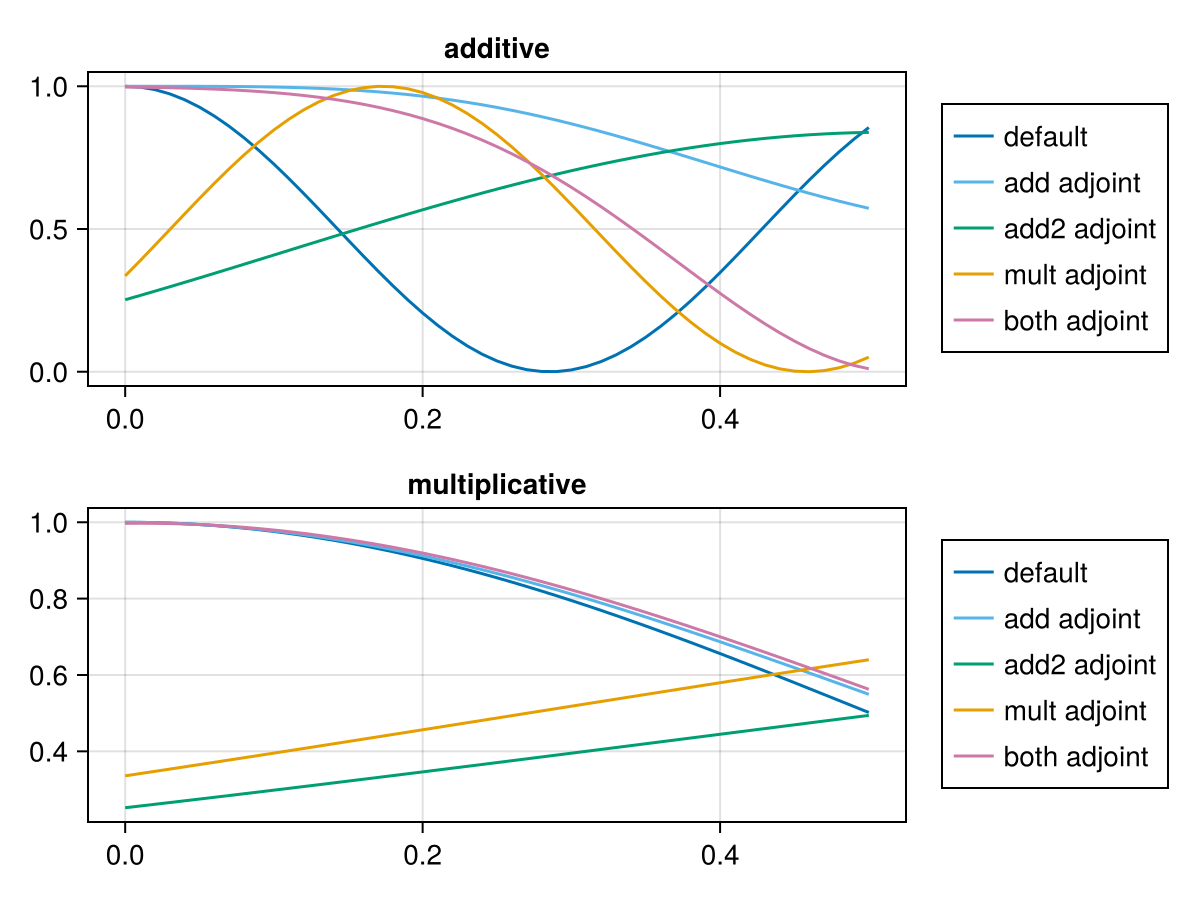

In [6]:
H_drive_add = H_drive

f = Figure()
ax1 = Axis(f[1, 1], title="additive")
ax2 = Axis(f[2, 1], title="multiplicative")

colors = Makie.wong_colors()

εs = 0:0.01:.5

# default case (smooth, non-variational, w/o toggling obj)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="default", color=colors[1], linestyle=:solid)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="default", color=colors[1], linestyle=:solid)

# adjoint-only (no toggling obj)

# (add)
ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="add adjoint", color=colors[5], linestyle=:solid)

ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="add adjoint", color=colors[5], linestyle=:solid)

# # (add2)
ys = [unitary_rollout_fidelity(add_prob_2.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="add2 adjoint", color=colors[3], linestyle=:solid)

ys = [unitary_rollout_fidelity(add_prob_2.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="add2 adjoint", color=colors[3], linestyle=:solid)

# (mult)
ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="mult adjoint", color=colors[2], linestyle=:solid)

ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="mult adjoint", color=colors[2], linestyle=:solid)

# (both)
ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="both adjoint", color=colors[4], linestyle=:solid)

ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="both adjoint", color=colors[4], linestyle=:solid)



Legend(f[1,2], ax1, position=:lb)
Legend(f[2,2], ax2, position=:lb)

f


sanity checks for the toggling frame

In [7]:
rob_default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; activate_rob_loss=true, H_err=Hₑ, Q_t=1.0)
solve!(rob_default, max_iter=200, print_level=5)

add_rob_prob = UnitaryVariationalProblem(
        varsys_add, U_goal, T, Δt;
        variational_scales=[rob_scale,rob_scale],
        robust_times=[[T],],
        activate_rob_loss=true,
        H_err=Hₑ,
        Q_s=0.0,
        Q_r=0.0,
        Q_t=1.0,
        piccolo_options=piccolo_opts
    )
solve!(add_rob_prob, max_iter=150, print_level=5)

add_rob_prob2 = UnitaryVariationalProblem(
        varsys, U_goal, T, Δt;
        variational_scales=[rob_scale,rob_scale],
        robust_times=[[T],],
        activate_rob_loss=true,
        H_err=Hₑ,
        Q_s=0.0,
        Q_r=0.0,
        Q_t=1.0,
        piccolo_options=piccolo_opts
    )
solve!(add_rob_prob2, max_iter=150, print_level=5)


mult_rob_prob = UnitaryVariationalProblem(
        varsys_mult, U_goal, T, Δt;
        variational_scales=[rob_scale,rob_scale],
        robust_times=[[T],],
        activate_rob_loss=true,
        H_err=Hₑ,
        Q_s=0.0,
        Q_r=0.0,
        Q_t=1.0,
        piccolo_options=piccolo_opts
    )
solve!(mult_rob_prob, max_iter=150, print_level=5)


both_rob_prob = UnitaryVariationalProblem(
        varsys_both, U_goal, T, Δt;
        variational_scales=[rob_scale,rob_scale],
        robust_times=[[T],],
        activate_rob_loss=true,
        H_err=Hₑ,
        Q_s=0.0,
        Q_r=0.0,
        Q_t=1.0,
        piccolo_options=piccolo_opts
    )
solve!(both_rob_prob, max_iter=150, print_level=5)

    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:     2082
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    24193

Total number of variables............................:      288
                     variables with only lower bounds:        0
                variables with 

In [1]:
H_drive_add = H_drive

f = Figure()
ax1 = Axis(f[1, 1], title="additive")
ax2 = Axis(f[2, 1], title="multiplicative")

colors = Makie.wong_colors()

εs = 0:0.01:.5

# default case (smooth, non-variational, w/o toggling obj)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(ε * (PAULIS.X), H_drive_add)) for ε in εs]
lines!(ax1, εs, ys, label="default", color=colors[1], linestyle=:solid)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem((1 + ε) * H_drive)) for ε in εs]
lines!(ax2, εs, ys, label="default", color=colors[1], linestyle=:solid)


# toggling-obj-only (no variational states)

ys = [unitary_rollout_fidelity(rob_default.trajectory, QuantumSystem(ε * (PAULIS.X), H_drive_add)) for ε in εs]
lines!(ax1, εs, ys, label="non-variational robust", color=colors[2], linestyle=:solid)

ys = [unitary_rollout_fidelity(rob_default.trajectory, QuantumSystem((1 + ε) * H_drive)) for ε in εs]
lines!(ax2, εs, ys, label="non-variational robust", color=colors[2], linestyle=:solid)

# Robust (addtive)

ys = [unitary_rollout_fidelity(add_rob_prob.trajectory, QuantumSystem(ε * (PAULIS.X), H_drive_add)) for ε in εs]
lines!(ax1, εs, ys, label="Robust (add)", color=colors[3], linestyle=:solid)

ys = [unitary_rollout_fidelity(add_rob_prob.trajectory, QuantumSystem((1 + ε) * H_drive)) for ε in εs]
lines!(ax2, εs, ys, label="Robust (add)", color=colors[3], linestyle=:solid)

# Robust (addtive2)
ys = [unitary_rollout_fidelity(add_rob_prob2.trajectory, QuantumSystem(ε * (PAULIS.X), H_drive_add)) for ε in εs]
lines!(ax1, εs, ys, label="Robust (add2)", color=colors[6], linestyle=:solid)

ys = [unitary_rollout_fidelity(add_rob_prob2.trajectory, QuantumSystem((1 + ε) * H_drive)) for ε in εs]
lines!(ax2, εs, ys, label="Robust (add2)", color=colors[6], linestyle=:solid)


# Robust (mult)
ys = [unitary_rollout_fidelity(mult_rob_prob.trajectory, QuantumSystem(ε * (PAULIS.X), H_drive_add)) for ε in εs]
lines!(ax1, εs, ys, label="Robust (mult)", color=colors[4], linestyle=:solid)

ys = [unitary_rollout_fidelity(mult_rob_prob.trajectory, QuantumSystem((1 + ε) * H_drive)) for ε in εs]
lines!(ax2, εs, ys, label="Robust (mult)", color=colors[4], linestyle=:solid)

# Robust (both)
ys = [unitary_rollout_fidelity(both_rob_prob.trajectory, QuantumSystem(ε * (PAULIS.X), H_drive_add)) for ε in εs]
lines!(ax1, εs, ys, label="Robust (both)", color=colors[5], linestyle=:dash)

ys = [unitary_rollout_fidelity(both_rob_prob.trajectory, QuantumSystem((1 + ε) * H_drive)) for ε in εs]
lines!(ax2, εs, ys, label="Robust (both)", color=colors[5], linestyle=:dash)


Legend(f[1,2], ax1, position=:lb)
Legend(f[2,2], ax2, position=:lb)

f

UndefVarError: UndefVarError: `H_drive` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Full seed

single pareto frontier for sanity check 

In [9]:
a_guess = [0.1*randn(2, T) for _ in 1:5]
a_bounds = fill(a_bound, 2)
da_bounds = fill(da_bound, 2)
dda_bounds = fill(dda_bound, 2)
control_bounds = (a_bounds, da_bounds, dda_bounds)
varsys_add_seeds = []
varsys_mult_seeds = []
# varsys_both_seeds = []

n_drives = varsys_add.n_drives

for i in 1:5
    add_traj = initialize_trajectory(
                    U_goal,
                    T,
                    Δt,
                    n_drives,
                    control_bounds;
                    a_guess=deepcopy(a_guess[i]),
                    system=varsys_add
                )
    push!(varsys_add_seeds, add_traj)

    mult_traj = initialize_trajectory(
                U_goal,
                T,
                Δt,
                n_drives,
                control_bounds;
                a_guess=deepcopy(a_guess[i]),
                system=varsys_mult
            )
    push!(varsys_mult_seeds, mult_traj)

    # both_traj = initialize_trajectory(
    #             U_goal,
    #             T,
    #             Δt,
    #             n_drives,
    #             control_bounds;
    #             a_guess=deepcopy(a_guess[i]),
    #             system=varsys_both
    #         )
    # push!(varsys_both_seeds, both_traj)
end

In [10]:
# εs = 0:0.01:.5
# error_magnitudes = [x for x in εs]

# for (ε_idx, ε) in enumerate(error_magnitudes)
#     # Calculate fidelities for each error magnitude
#         # Additive case
#         add_err_sys = QuantumSystem(ε * (H_drive), [H_drive_add])
#         add_fidelity = unitary_rollout_fidelity(prob.trajectory, add_err_sys)
#         additive_fidelities[ε_idx] = add_fidelity
        
#         # Multiplicative case
#         mult_err_sys = QuantumSystem([(1 + ε) * H_drive])
#         mult_fidelity = unitary_rollout_fidelity(prob.trajectory, mult_err_sys)
#         multiplicative_fidelities[ε_idx, λ_idx] = mult_fidelity
#     end
# end

# # Plot 1: Additive Error - Fidelity vs Robustness for different error magnitudes
# # Robustness ≡ |tr(R'R)|, where R = ∑ₜ(uₜ' Hₑ uₜ)
# p1 = Plots.plot(xlabel="Robustness", 
#         ylabel="Fidelity",
#         title="Additive Error: Fidelity vs Robustness",
#         legendfontsize=10, titlefontsize=12,
#         grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3,
#         legend=:topright)

# for (ε_idx, ε) in enumerate(error_magnitudes)
#     Plots.plot!(p1, obj_vals[ε_idx, :], additive_fidelities[ε_idx, :],
#         label="ε = $ε", 
#         marker=:circle, markersize=3, linewidth=2)
# end

# # Plot 2: Multiplicative Error - Fidelity vs Robustness for different error magnitudes
# p2 = Plots.plot(xlabel="Robustness", 
#         ylabel="Fidelity",
#         title="Multiplicative Error: Fidelity vs Robustness",
#         legendfontsize=10, titlefontsize=12,
#         grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3,
#         legend=:topright)

# for (ε_idx, ε) in enumerate(error_magnitudes)
#     Plots.plot!(p2, obj_vals[ε_idx, :], multiplicative_fidelities[ε_idx, :], 
#         label="ε = $ε", 
#         marker=:square, markersize=3, linewidth=2)
# end


# # Display all plots
# display(p1)
# display(p2)


single seed check

In [11]:
# εs = 0:0.01:.5
add_seed = varsys_add_seeds[1]
mult_seed = varsys_mult_seeds[1]
n_lambdas = length(sweep_rob_loss_λ)
n_errors = length(error_magnitudes)
# Store fidelities for each lambda and error combination
additive_fidelities = []
multiplicative_fidelities = []
obj_vals = []

for (ε_idx, ε) in enumerate(error_magnitudes)
    # Calculate fidelities for each error magnitude
        obj = QuantumObjectives.FirstOrderObjective(Hₑ, mult_rob_prob.trajectory, [T]; Q_t=1.0)#prob.trajectory.Ũ⃗ᵥ1[:, end]
        Z_vec = vec(mult_rob_prob.trajectory)
        obj_val = obj.L(Z_vec)
        push!(obj_vals, obj_val)
        
        # Additive case
        add_err_sys = QuantumSystem(ε * (PAULIS.X), H_drive_add)
        add_fidelity = unitary_rollout_fidelity(mult_rob_prob.trajectory, add_err_sys)
        push!(additive_fidelities, add_fidelity)
        
        # Multiplicative case
        mult_err_sys = QuantumSystem((1 + ε) * H_drive)
        mult_fidelity = unitary_rollout_fidelity(mult_rob_prob.trajectory, mult_err_sys)
        push!(multiplicative_fidelities, mult_fidelity)
end

max = maximum(obj_vals)

# Plot 1: Additive Error - Fidelity vs Robustness for different error magnitudes
p1 = Plots.plot(xlabel="Robustness ≡ |tr(R'R)|, where R = ∑ₜ(uₜ' Hₑ uₜ)", 
        xlims=(0, max),
        ylabel="Fidelity",
        title="Additive Error: Fidelity vs Robustness (unitless)",
        legendfontsize=10, titlefontsize=12,
        grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3,
        legend=:topright)

for (ε_idx, ε) in enumerate(error_magnitudes)
    Plots.plot!(p1, obj_vals, additive_fidelities,
        label="ε = $ε", 
        marker=:circle, markersize=3, linewidth=2)
end

# Plot 2: Multiplicative Error - Fidelity vs Robustness for different error magnitudes
p2 = Plots.plot(xlabel="Robustness ≡ |tr(R'R)|, where R = ∑ₜ(uₜ' Hₑ uₜ)", 
        xlims=(0, max),
        ylabel="Fidelity",
        title="Multiplicative Error: Fidelity vs Robustness (unitless)",
        legendfontsize=10, titlefontsize=12,
        grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3,
        legend=:topright)

for (ε_idx, ε) in enumerate(error_magnitudes)
    Plots.plot!(p2, obj_vals, multiplicative_fidelities, 
        label="ε = $ε", 
        marker=:square, markersize=3, linewidth=2)
end


# Display all plots
display(p1)
display(p2)


# Detailed results table
println("\n=== Detailed Results Table ===")
for (ε_idx, ε) in enumerate(error_magnitudes)
    println("\nε = $ε:")
    println(" Add Fidelity | Mult Fidelity")
    println("-" ^ 40)
    println("$(lpad(round(additive_fidelities[ε_idx], digits=6), 12)) | $(lpad(round(multiplicative_fidelities[ε_idx], digits=6), 13))")
end

UndefVarError: UndefVarError: `sweep_rob_loss_λ` not defined in `Main`
Suggestion: check for spelling errors or missing imports.